# Figure 1

Visual presentation of decision rollouts in four different scenarios. Each rollout consists of the decisions of three players for fifteen rounds. Rows correspond to players and columns to rounds. Blue cells represent ''go'' decisions, and gray cells represent ''do not go'' decisions. Each rollout represents a different pattern (see text for details).

+ Otras cosas

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Classes.bar import Bar
from Config.config import PATHS

In [2]:
def plot_stability(list_of_alternations, list_of_titles, num_rounds):
	fig, axes = plt.subplots(len(list_of_alternations))
	for i, alternations in enumerate(list_of_alternations):
		# Detect number of agents
		num_agents = len(alternations[0])
		# Create bar object
		bar = Bar(
			num_agents=num_agents,
			threshold=0.5
		)
		bar.history = alternations * (num_rounds // len(alternations)) + alternations[:num_rounds % len(alternations)]
		attendance_file_name = None #'alternations.png'
		bar.render(
			ax=axes[i],
			file=attendance_file_name,
			num_rounds=len(bar.history)
		)
#		axes[i].imshow(plt.imread(attendance_file_name))
		if list_of_titles is not None:
			axes[i].set_title(list_of_titles[i])
		axes[i].axis('off')
	fig.tight_layout()
	fig.savefig(PATHS['figures_for_paper'] / 'Panel_A_Fig1.png', dpi=300)
	fig.show()

C:\Users\edgar.andrade\AppData\Local\Temp\ipykernel_26076\3338451545.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


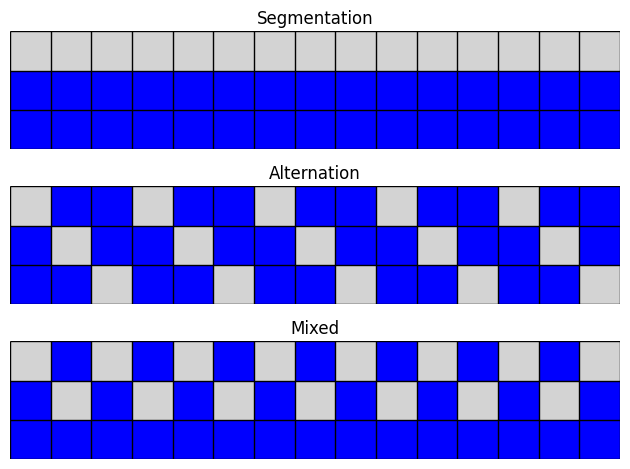

In [3]:
num_rounds = 15
list_of_alternations = [
	# [np.random.randint(0, 2, 3).tolist() for _ in range(num_rounds)],
	[[1, 1, 0]],
	[[1, 1, 0], [1, 0, 1], [0, 1, 1]],
	[[1, 1, 0], [1, 0, 1]],
]
plot_stability(
    list_of_alternations=list_of_alternations, 
    list_of_titles = ['Segmentation', 'Alternation', 'Mixed'],
    num_rounds=num_rounds
)

In [4]:
from Classes.bar import Bar
from Classes.cognitive_model_agents import AttendanceM3

free_paramters = {
    'inverse_temperature': 32,
    'bias': 0.5,
    'learning_rate':0.1,
    'len_history':2,
    'delta':1
}
fixed_parameters = {
    'num_agents':2,
    'threshold':0.5
}

Text(-0.1, 0.235, 'Pl2')

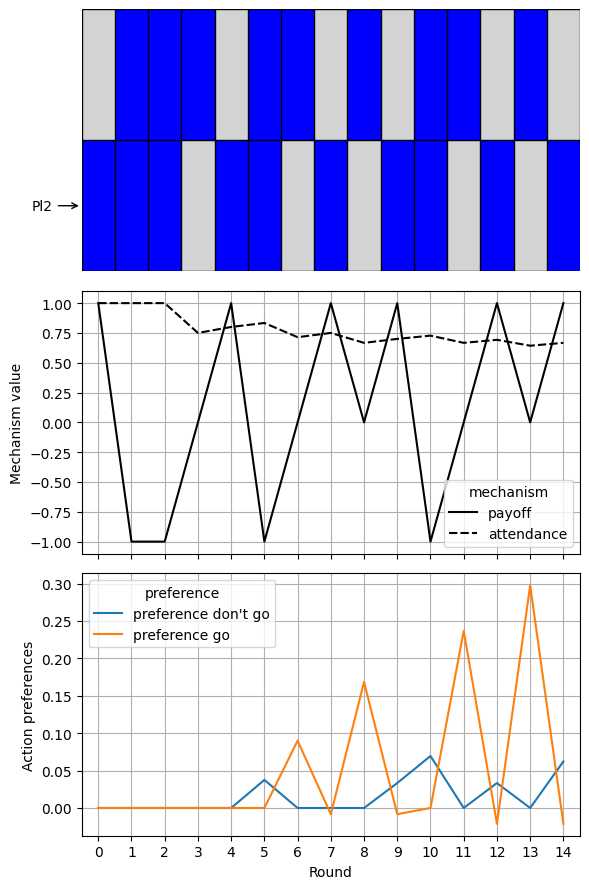

In [7]:
bar = Bar(**fixed_parameters)
agent = AttendanceM3(
    free_parameters=free_paramters,
    fixed_parameters=fixed_parameters,
    n=0
)
other_agent = AttendanceM3(
    free_parameters=free_paramters,
    fixed_parameters=fixed_parameters,
    n=1
)
payoffs = []
attendances = []
preference_go = []
preference_no_go = []
actions = [
    [1, 1, 1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 1, 1, 0, 1],
    # [0, 1, 1, 1, 1, 0, 1],
    # [1, 1, 1, 0, 1, 1, 0],
    # [0, 1, 0, 1],
    # [1, 0, 1, 0],
]
actions = np.array(actions).T.tolist()

num_rounds = 15
for i in range(num_rounds):
    if i < len(actions):
        decisions = actions[i]
    else:
        player1 = agent.make_decision()
        player2 = other_agent.make_decision()
        decisions = [player1, player2]
    # Update bar with decisions
    attendance, scores = bar.step(decisions)
    # Find payoff
    payoff = agent.payoff(decisions[0], decisions)
    payoffs.append(payoff)
    # Find attendances
    average_go = np.mean(agent.decisions + [decisions[0]])
    attendances.append(average_go)
    # Update agents with decisions
    agent.update(scores[0], decisions)
    other_agent.update(scores[0], decisions)
    # Find preference not going
    preferences = agent.determine_action_preferences()
    preference_no_go.append(preferences[0])
    preference_go.append(preferences[1])

fig, ax = plt.subplots(
    3, 1, 
    figsize=(6,9), 
    tight_layout=True,
)

bar.render(ax=ax[0], num_rounds=num_rounds)

n1, n2 = len(payoffs), len(attendances)
df_values = pd.DataFrame({
    'round': list(range(n1)) + list(range(n2)),
    'value': payoffs + attendances,
    'mechanism': ["payoff"]*n1  + ["attendance"]*n2
})

n1, n2 = len(preference_no_go), len(preference_go)
df_preferences = pd.DataFrame({
    'round': list(range(n1)) + list(range(n2)),
    'value': preference_no_go + preference_go,
    'preference': ["preference don't go"]*n1 + ["preference go"]*n2
})


sns.lineplot(
    x="round", y="value", style="mechanism",
    style_order=["payoff", "attendance"],
    data=df_values, ax=ax[1],
    color='black'
)
ax[1].grid()
ax[1].set_ylabel('Mechanism value')
ax[1].set_xlim([-0.5, num_rounds - 0.5])
ax[1].set_xlabel('')
ax[1].set_xticks(range(num_rounds)) 
ax[1].set_xticklabels([])

sns.lineplot(
    x="round", y="value", hue="preference",
    hue_order=["preference don't go", "preference go"],
    data=df_preferences, ax=ax[2],
    color='black'
)
ax[2].set_ylabel('Action preferences')

ax[2].set_xlabel('Round')
ax[2].set_xlim([-0.5, num_rounds - 0.5])
ax[2].set_xticks(range(num_rounds)) 
ax[2].set_xticklabels(range(num_rounds))
ax[2].grid()

ax[0].annotate(
    'Pl2',
    xy=(0, 0.25), xycoords='axes fraction',
    xytext=(-0.1, 0.235), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
)


In [8]:
fig.savefig(PATHS['figures_for_paper'] / 'Panel_D_Fig1.png', dpi=300)